<a href="https://colab.research.google.com/github/takao8/MLTSA_JClifford/blob/master/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
!pip install fbprophet

In [0]:
import fbprophet
from fbprophet import Prophet
from fbprophet import diagnostics

In [0]:
a = []
for mon in enumerate(['apr', 'may', 'jun', 'jul', 'aug', 'sep']):
  c = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-' + mon[1] + '14.csv')
  a.append(c)
a = pd.concat(a)

In [0]:
a["Date/Time"] = pd.to_datetime(a["Date/Time"])
#a = a["Date/Time"]

# Forming Count Data

Now we'll adjust the data to count the number of instances per day.

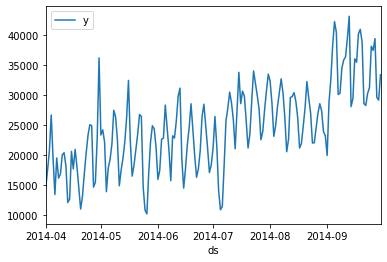

In [0]:
a = a.groupby(a["Date/Time"].dt.date).count()
a['ds'] = a.index
a = a.rename(columns={"Date/Time": "y"})
a = a.drop(columns=["Lat", "Lon", "Base"])
a.plot(x = "ds", y = "y")

Figure 1: Plot of the count of the number of uber rides over time, from April to September of 2014

# Standardizing the Data

And we'll standardize too, to finish our data preperation.

In [0]:
a["y"] = (a["y"] - a["y"].mean()) / a["y"].std()

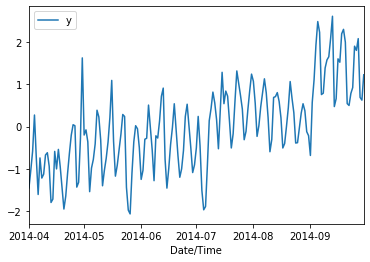

In [0]:
a.plot()

Figure 2: The standardized plot of Figure 1, subtracting its mean and dividing by its standard deviation.  Performed to prevent large numbers and to convert our values to floating point numbers instead of integers

# DATA ANALYSIS

## Model 1: Trends and Seasonality

In [0]:
simplem = Prophet()
simplem.fit(a)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = simplem.make_future_dataframe(periods=40)
forecast = simplem.predict(future)

In [0]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
218,2014-11-05,1.977357,1.254371,2.617413
219,2014-11-06,2.296539,1.650402,2.963193
220,2014-11-07,2.220377,1.533683,2.907748
221,2014-11-08,1.703405,1.003741,2.313420
222,2014-11-09,0.855040,0.225434,1.529668


This table illustrates our prediction (yhat), our lower bound error (yhat_lower), and our upper bound error (yhat_upper).

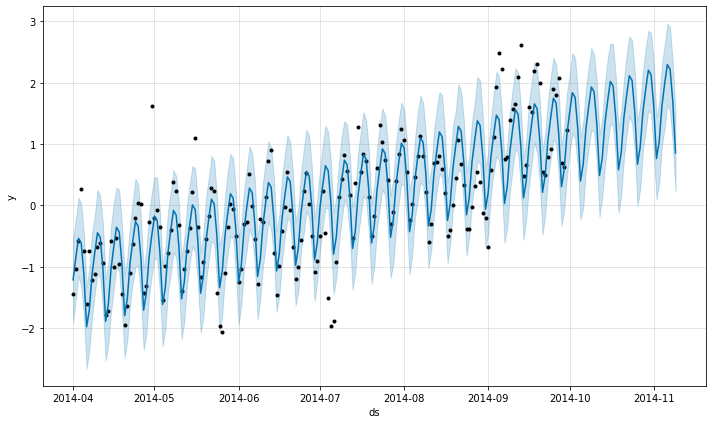

In [0]:
fig1 = simplem.plot(forecast)

Figure 3: Future forecast of our series, 40 days into the future.  The dark colored line is our prediction, while the light colored band represents the uncertainty in our prediction.

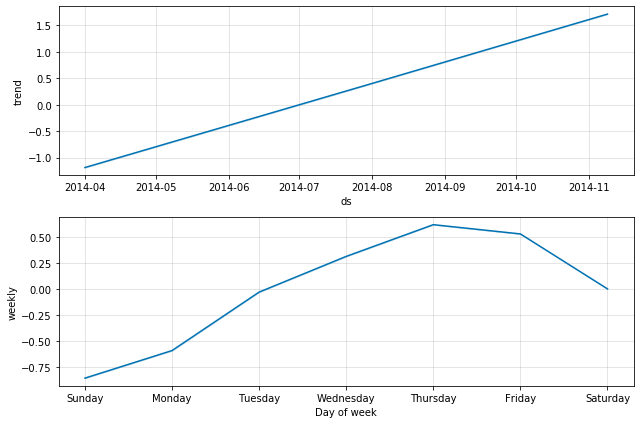

In [0]:
fig2 = simplem.plot_components(forecast)

Figure 4: Components of our forecast.  The top plot illustrates the trend increase in ridership over the course of 2014, while the bottom plot indicates the likelihood that people will take ubers on certain days of the week; lowest on Sundays, with a gradual increase to a peak on Thursdays.

# Model Validation of Model 1

First, we do our cross validation, with a horizon set at 30 days

In [0]:
cv = diagnostics.cross_validation(simplem, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


Then, we define our reduced chi^2 function:

In [0]:
def rchi2(y, yhat):
  return sum((y - yhat)**2) / len(y)

Giving the following error:

In [0]:
rchi2(cv["y"], cv["yhat"])

0.4602355257526829

With the rchi2 value < 1, this is an indication of potential overfitting.

# Data Acquisition for Weather Data

In this step, we acquire NYC weather data in accordance to the uberride data we have.  We'll use the weather data to help regress the series.

In [0]:
!pip install wwo_hist

In [0]:
from wwo_hist import retrieve_hist_data

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]


In [0]:
frequency = 24   #frequency in hours
start_date = "01-APR-2014"
end_date = "30-SEP-2014"
api_key = '064ed2ad50464135beb181324200703'
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:01.484286
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:03.305212
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:04.747764
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:06.238814
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:07.777878
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:09.356530
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:10.819279


export New+york,ny completed!




Now the data is extracted, we'll read it in and do our analysis.

In [0]:
nydat = pd.read_csv('New+york,ny.csv')
nydat["date_time"] = pd.to_datetime(nydat["date_time"])
nydat.set_index("date_time", inplace=True)
nydat = nydat[["tempC", "precipMM"]]

In [0]:
tot = a.merge(nydat, left_index=True, right_index=True)

In [0]:
tot

,y,ds,tempC,precipMM
2014-04-01,-1.449528,2014-04-01,12,0.0
2014-04-02,-1.034719,2014-04-02,12,0.2
2014-04-03,-0.577551,2014-04-03,13,0.0
2014-04-04,0.274309,2014-04-04,6,4.5
2014-04-05,-0.744721,2014-04-05,10,0.1
...,...,...,...,...
2014-09-28,0.691101,2014-09-28,26,0.0
2014-09-29,0.626642,2014-09-29,24,0.1
2014-09-29,0.626642,2014-09-29,24,0.1
2014-09-30,1.225904,2014-09-30,21,0.8


Text(0, 0.5, '(mm)')

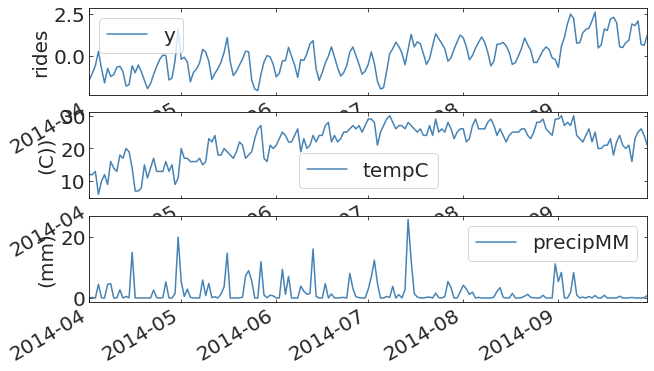

In [222]:
fig, ax = pl.subplots(3)
ax1 = tot.plot(y="y", ax=ax[0])
ax1.set_ylabel("rides")
ax2 = tot.plot(y="tempC", ax=ax[1])
ax2.set_ylabel("(C))")
ax3 = tot.plot(y="precipMM", ax=ax[2])
ax3.set_ylabel("(mm)")


Figure 5: Plots of the uberrides data (y), temperature data (tempC), and percipitation data (percipMM)

# Model 2: Using Weather Data

Now we create another regression, using the weather data.

In [0]:
regrm = Prophet()

In [0]:
regrm.add_regressor("tempC")
regrm.add_regressor("precipMM")

In [0]:
regrm.fit(tot)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
fut = regrm.predict(tot)

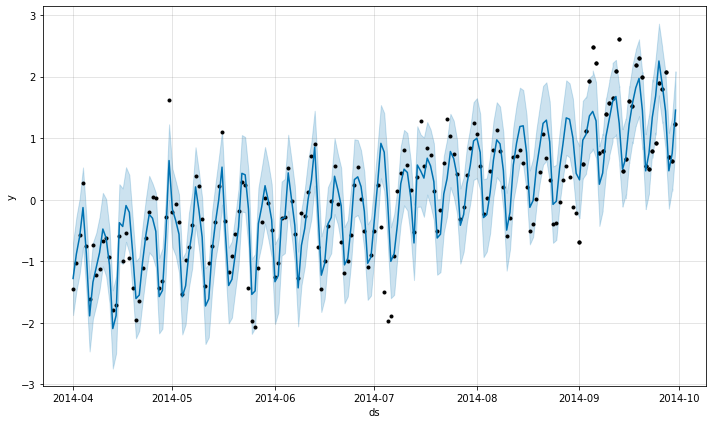

In [0]:
ax = regrm.plot(fut)

Figure 6: Fit of the uberrides time series, with weather data as regressors.

: Plot of the prediction of our time series.

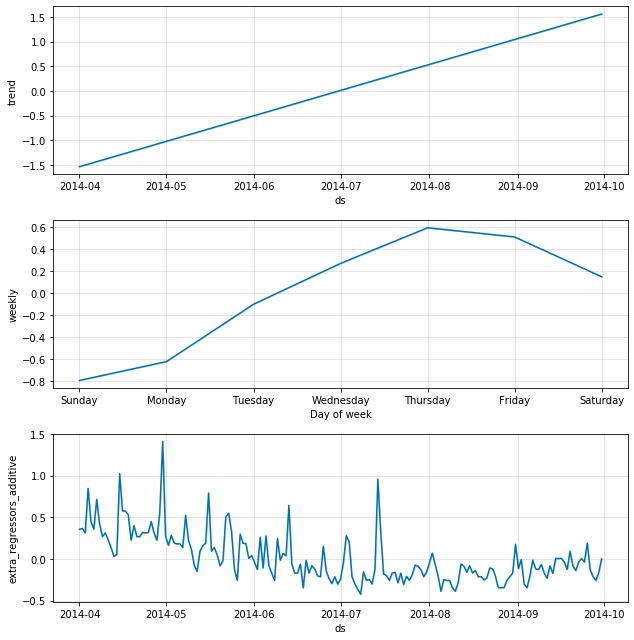

In [0]:
ax = regrm.plot_components(fut)

Figure 7: Component plots of our forecast, similar to Figure 4, except with the bottom plot that indicates the component our regressors include over time.  Note that our regressors become more insignificant (closer to 0) as time progresses, indicating that they might not be as useful in the later months.

In [0]:
cv2 = diagnostics.cross_validation(regrm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [0]:
rchi2(cv2["y"], cv2["yhat"])

0.5350198918414736

This is better! The closer to 1, the better our model is.

# Model 3: Adding Holidays

In [115]:
regholm = Prophet()
regholm.add_country_holidays("US")
regholm.add_regressor("tempC")
regholm.add_regressor("precipMM")
regholm.fit(tot)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


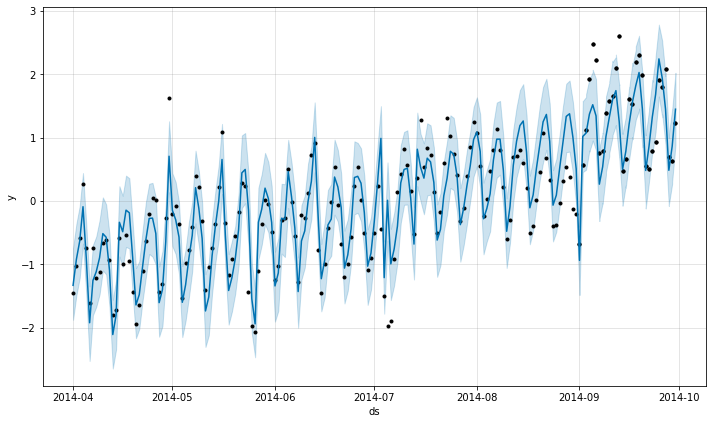

In [116]:
fut2 = regholm.predict(tot)
ax2 = regholm.plot(fut2)

Figure 8: Fit of the uberrides time series, with weather data as regressors and holidays as components.  Note signs of overfitting: at the 2014-09 point, a large spike down is done corresponding to the lower datapoint.  Extreme spikes are an initial sign that we have too many predictors, or are not getting enough signal out of our model.

In [117]:
cv3 = diagnostics.cross_validation(regholm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [118]:
rchi2(cv3["y"], cv3["yhat"])

0.4520665060666661

Indicative that holidays might not be the best predictor--the rchi2 value approaching 0 indicates that we're overfitting again.

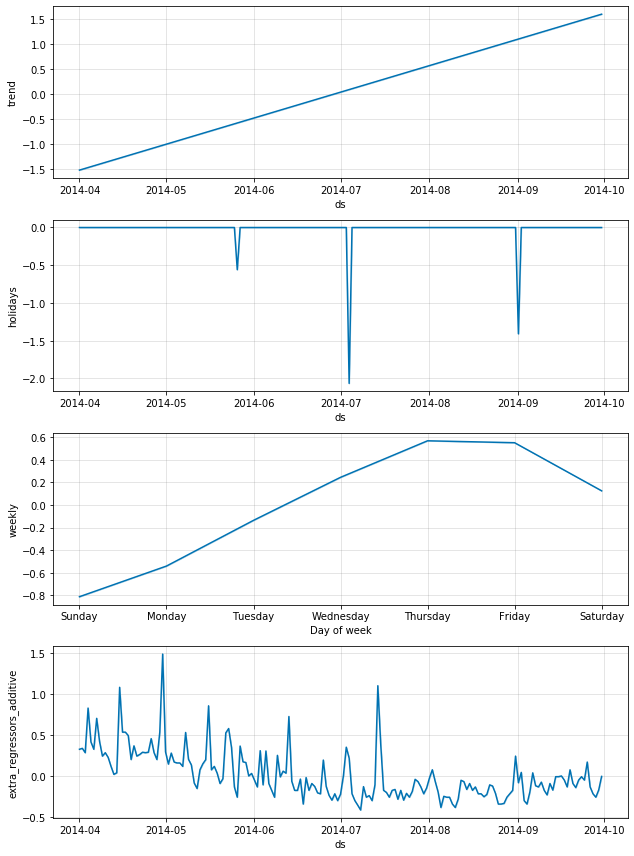

In [122]:
ax3 = regholm.plot_components(fut2)

Figure 9: Component plot of our time series, similar to Figure 4 and Figure 7, except with the holidays figure.  Note the spikes around Memorial Day (late May), Independence day (early July), and Labor day (early September).

# Model 4: Using Markov Chain Monte Carlo 

Now instead of doing our minimization with gradient descent, we'll use Markov chain Monte Carlo methods, and see how our results change.

In [123]:
regmcmc = Prophet(mcmc_samples=500)
regmcmc.add_country_holidays("US")
regmcmc.add_regressor("tempC")
regmcmc.add_regressor("precipMM")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


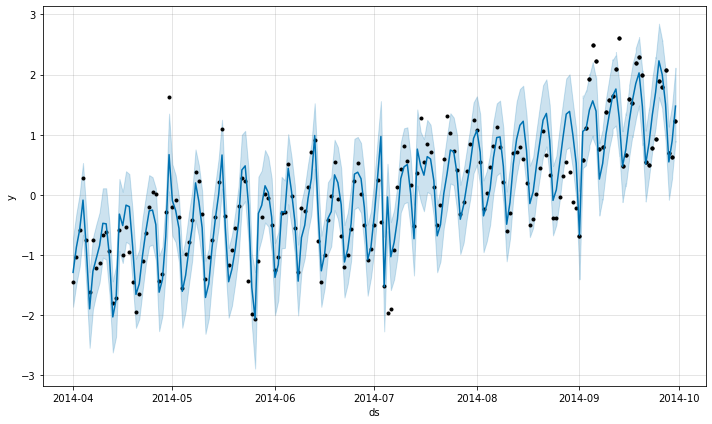

In [124]:
regmcmc.fit(tot)
fut3 = regmcmc.predict(tot)
ax4 = regmcmc.plot(fut3)

Figure 10: Fit of the ubberides data with weather as regressors, holidays, and using Markov chain Monte Carlo (MCMC) for evaluating the posterior instead of standard/stochastic gradient descent.  MCMC ensures that the entire sample space is explored over time as $t \to \infty$, thus is less likely to produce local minima.

In [125]:
cv4 = diagnostics.cross_validation(regmcmc, horizon='30 days')
rchi2(cv4["y"], cv4["yhat"])

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.5412722877058723

Using MCMC increased the rchi2 again.  This is our best result yet.

# Extra: pydlm Application

In this section, we'll use pydlm to recreate some of the results we obtained.

In [143]:
pip install pydlm

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for pydlm: filename=pydlm-0.1.1.11-py2.py3-none-any.whl size=58997 sha256=7e94eecea74d026fe98b2eb15ff6d95515df956b6a2c07564b06c63a4530d679
  Stored in directory: /root/.cache/pip/wheels/69/d3/ca/f5a7bc0976a2779bf87c20f82a9adece40616ee3b9d39bf410
Successfully built pydlm


In [0]:
from pydlm import dlm, trend, seasonality
from pydlm import dynamic

In [0]:
linear_trend = trend(degree=1, discount=0.96, name='linear_trend', w=10)
regressor10 = dynamic(features=tot[["tempC", "precipMM"]].to_numpy(), discount=1.0, name='regressor10', w=10)
seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=10)
simple_dlm = dlm(tot["y"].to_numpy()) + regressor10 + linear_trend + seasonal52

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


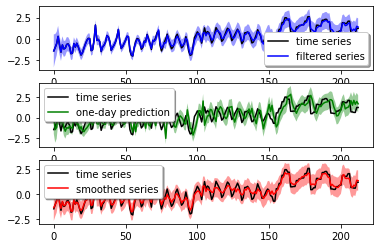

In [203]:
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

Figure 11: This plot shows the results of forward-backward filtering and of a one-day prediction.  For our purposes, the one-day prediction is what matters the most, as it indicates predictive power of the series for one day into the future.  The plots are as follows: Blue: forward filtering, Green: one day ahead, Red: backward filtering

In [204]:
simple_dlm.getMSE()

0.7233029509310359

This is our mean-squared error.

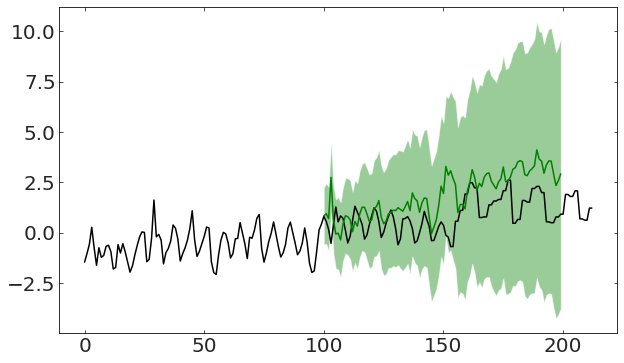

In [223]:
simple_dlm.plotPredictN(date=100, N=100)

Figure 12: Predictions for 100 days into the future using the first 100 data points.  The error bars indicate that we can do a better job at prediction by changing the model.